# Credit Card Default Taiwan Dataset

# 1. Import packages and load dataset

In [3]:
import numpy as np 
import pandas as pd 
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV 
from sklearn.pipeline import Pipeline 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

#need to install catboost package in your anaconda prompt. pip install catboost
from catboost import CatBoostClassifier, cv, Pool

from sklearn.metrics import mean_squared_error as mse

# pd.set_option('display.max_columns', 500)
pd.set_option("display.max_columns", 100)
pd.options.display.float_format = '{:.3f}'.format
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
# # Widen width of notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [7]:
#Import dataset
os.chdir('C:/Users/weiji/OneDrive/Desktop/BT5151 Foundations in Data Science')

df = pd.read_excel('default-payment.xlsx', header = 1)

In [8]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [9]:
#transform the columns, remove white spaces and replace with '_' and convert to uppercase
df.columns = df.columns.str.replace(' ', '_').str.upper()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

# 2. Exploratory Data Analysis and Visualisation

In [11]:
#check the demographic variables
df[['SEX','EDUCATION','MARRIAGE','AGE']].describe()

,SEX,EDUCATION,MARRIAGE,AGE
count,30000.000,30000.000,30000.000,30000.000
mean,1.604,1.853,1.552,35.486
std,0.489,0.790,0.522,9.218
min,1.000,0.000,0.000,21.000
25%,1.000,1.000,1.000,28.000
50%,2.000,2.000,2.000,34.000
75%,2.000,2.000,2.000,41.000
max,2.000,6.000,3.000,79.000


<font color = red>based on data description in pdf, there are unclassified labels in education ('5 and 6') and in marriage ('0')

In [12]:
#recode gender and check values
df['SEX'] = df['SEX'].replace({1: 'MALE', 2: 'FEMALE' })
df['SEX'].value_counts()


FEMALE    18112
MALE      11888
Name: SEX, dtype: int64

In [13]:
#recode education values 5,6,0 as 'UNKNOWN'

df['EDUCATION'] = df['EDUCATION'].replace({1: 'GRADUATE_SCHOOL', 2: 'UNIVERSITY', 3:'HIGH_SCHOOL', 4:'OTHERS', 5:'UNKNOWN', 6:'UNKNOWN', 0:'UNKNOWN' })

df['EDUCATION'].value_counts()



UNIVERSITY         14030
GRADUATE_SCHOOL    10585
HIGH_SCHOOL         4917
UNKNOWN              345
OTHERS               123
Name: EDUCATION, dtype: int64

In [14]:
#recode marriage value 0 as 'UNKNOWN'

df['MARRIAGE'] = df['MARRIAGE'].replace({1: 'MARRIED', 2: 'SINGLE', 3:'OTHERS', 0:'UNKNOWN'})

df['MARRIAGE'].value_counts()

#0 label as unknown?

SINGLE     15964
MARRIED    13659
OTHERS       323
UNKNOWN       54
Name: MARRIAGE, dtype: int64

In [15]:
#bin the age category into groups and drop age column
 
df['AGE_GROUP'] = pd.cut(df['AGE'], bins=[20, 29, 39, 49, 59, 69, 79], labels=['20s', '30s', '40s', '50s', '60s','70s'])

df = df.drop(['AGE'], axis = 1)
df['AGE_GROUP'].value_counts()

30s    11238
20s     9618
40s     6464
50s     2341
60s      314
70s       25
Name: AGE_GROUP, dtype: int64

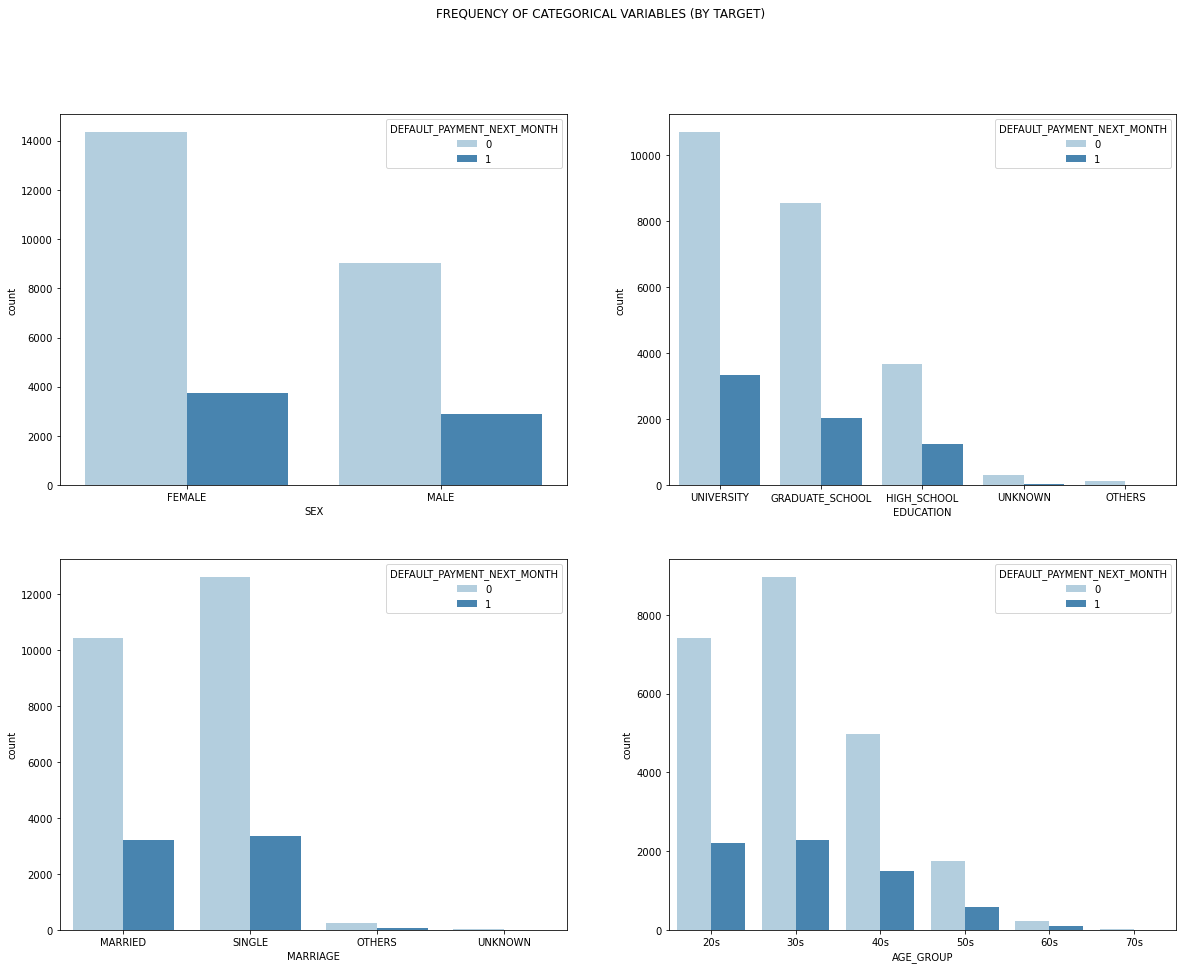

In [16]:
subset = df[['SEX', 'EDUCATION', 'MARRIAGE', 'AGE_GROUP', 'DEFAULT_PAYMENT_NEXT_MONTH']]

f, axes = plt.subplots(2, 2, figsize=(20, 15), facecolor='white')
f.suptitle('FREQUENCY OF CATEGORICAL VARIABLES (BY TARGET)')

ax1 = sns.countplot(x="SEX", hue="DEFAULT_PAYMENT_NEXT_MONTH", data=subset, palette="Blues", ax=axes[0,0])
ax2 = sns.countplot(x="EDUCATION", hue="DEFAULT_PAYMENT_NEXT_MONTH", data=subset, palette="Blues",ax=axes[0,1])
ax3 = sns.countplot(x="MARRIAGE", hue="DEFAULT_PAYMENT_NEXT_MONTH", data=subset, palette="Blues",ax=axes[1,0])
ax4 = sns.countplot(x="AGE_GROUP", hue="DEFAULT_PAYMENT_NEXT_MONTH", data=subset, palette="Blues",ax=axes[1,1])

In [17]:
#check the repayment status
df[['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']].describe()

,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
count,30000.000,30000.000,30000.000,30000.000,30000.000,30000.000
mean,-0.017,-0.134,-0.166,-0.221,-0.266,-0.291
std,1.124,1.197,1.197,1.169,1.133,1.150
min,-2.000,-2.000,-2.000,-2.000,-2.000,-2.000
25%,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000
50%,0.000,0.000,0.000,0.000,0.000,0.000
75%,0.000,0.000,0.000,0.000,0.000,0.000
max,8.000,8.000,8.000,8.000,8.000,8.000


In [18]:
#check the unique values of the pay columns
np.unique(df[['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']].values)


array([-2, -1,  0,  1,  2,  3,  4,  5,  6,  7,  8], dtype=int64)

<font color = red>based on the data description, there are two unclassified labels which are '-1' and '-2'

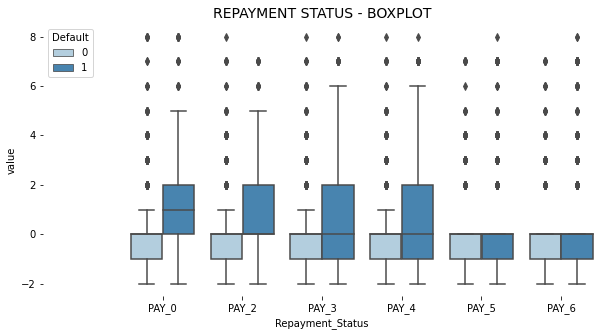

In [19]:
Repayment = df[['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6','DEFAULT_PAYMENT_NEXT_MONTH']]

Repayment = pd.melt(Repayment,id_vars="DEFAULT_PAYMENT_NEXT_MONTH",
                    var_name="Repayment_Status",
                    value_name='value')


plt.figure(figsize=(10,5))
#sns.set_context('notebook', font_scale=1.2)
sns.boxplot(y="value", x="Repayment_Status", hue="DEFAULT_PAYMENT_NEXT_MONTH", data=Repayment, palette='Blues')
#plt.ylim(-5,5)
plt.legend(loc='best', title= 'Default', facecolor='white')

plt.xlim([-1.5,5.5])
plt.title('REPAYMENT STATUS - BOXPLOT', size=14)
plt.box(False)

# plt.savefig('ImageName', format='png', dpi=200);

<font color = red>For those who default, they have longer duration in payment delays. Also, there seems to be negative duration in payment delay?

In [20]:
#relabel the pay columns, all negative values to be laballed as zero

df[['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']] = df[['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']].replace({-2: 0 , -1: 0})



In [21]:
#check the bill amount status
df[['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5', 'BILL_AMT6']].describe()

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6
count,30000.000,30000.000,30000.000,30000.000,30000.000,30000.000
mean,51223.331,49179.075,47013.155,43262.949,40311.401,38871.760
std,73635.861,71173.769,69349.387,64332.856,60797.156,59554.108
min,-165580.000,-69777.000,-157264.000,-170000.000,-81334.000,-339603.000
25%,3558.750,2984.750,2666.250,2326.750,1763.000,1256.000
50%,22381.500,21200.000,20088.500,19052.000,18104.500,17071.000
75%,67091.000,64006.250,60164.750,54506.000,50190.500,49198.250
max,964511.000,983931.000,1664089.000,891586.000,927171.000,961664.000


C:\Users\weiji\AppData\Local\Continuum\anaconda3\envs\r-tutorial\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\weiji\AppData\Local\Continuum\anaconda3\envs\r-tutorial\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Object `plt.savefig('ImageName', format='png', dpi=200);` not found.


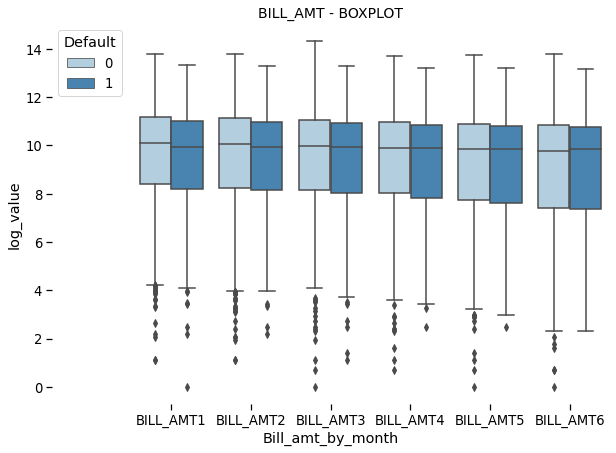

In [22]:
bill_amt = df[['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5', 'BILL_AMT6','DEFAULT_PAYMENT_NEXT_MONTH']]

bill_amt = pd.melt(bill_amt,id_vars="DEFAULT_PAYMENT_NEXT_MONTH",
                    var_name="Bill_amt_by_month",
                    value_name='value')

plt.figure(figsize=(10,7))
sns.set_context('notebook', font_scale=1.2)
bill_amt["log_value"] = np.log(bill_amt["value"])
sns.boxplot(y="log_value", x="Bill_amt_by_month", hue="DEFAULT_PAYMENT_NEXT_MONTH", data=bill_amt, palette='Blues')
plt.legend(loc='best', title= 'Default', facecolor='white')
plt.xlim([-1.5,5.5])
#plt.ylim([-70000,170000])
plt.title('BILL_AMT - BOXPLOT', size=14)
plt.box(False)
?plt.savefig('ImageName', format='png', dpi=200);

<font color = red> Observations: Those who are non-defaulters seem to be spending more money. Also, there are negative bill amounts, could it be credit?

In [23]:
#check the repayment status
df[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].describe()

,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,30000.000,30000.000,30000.000,30000.000,30000.000,30000.000
mean,5663.581,5921.163,5225.681,4826.077,4799.388,5215.503
std,16563.280,23040.870,17606.961,15666.160,15278.306,17777.466
min,0.000,0.000,0.000,0.000,0.000,0.000
25%,1000.000,833.000,390.000,296.000,252.500,117.750
50%,2100.000,2009.000,1800.000,1500.000,1500.000,1500.000
75%,5006.000,5000.000,4505.000,4013.250,4031.500,4000.000
max,873552.000,1684259.000,896040.000,621000.000,426529.000,528666.000


In [24]:
pay_amt = df[['PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5', 'PAY_AMT6','DEFAULT_PAYMENT_NEXT_MONTH']]
month_list = ['PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5', 'PAY_AMT6']
for pay in month_list:
    pay_amt[pay+'_GROUP'] = pd.cut(pay_amt[pay], bins=[-1, 0, 100, 1000, 10000, 10e5, 10e6],
                                       labels=['0', '0-100', '100-1000', '1000-10000', '10e4-10e5','10e5-10e6'])
    pay_amt = pay_amt.drop([pay], axis = 1)
pay_amt['value_count'] = np.zeros(shape=len(pay_amt))

C:\Users\weiji\AppData\Local\Continuum\anaconda3\envs\r-tutorial\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [25]:
# count = pay_amt.groupby(['DEFAULT_PAYMENT_NEXT_MONTH','PAY_AMT1_GROUP']).count()
pay_amt_count = pd.DataFrame()
column_to_count = ['PAY_AMT1_GROUP','PAY_AMT2_GROUP','PAY_AMT3_GROUP','PAY_AMT4_GROUP','PAY_AMT5_GROUP','PAY_AMT6_GROUP']
column_name = ['AMT1','AMT2','AMT3','AMT4','AMT5','AMT6']
for (col, col_name) in zip(column_to_count, column_name):
    count = pay_amt.groupby(['DEFAULT_PAYMENT_NEXT_MONTH',col]).count()
    pay_amt_count[col_name]  = count['value_count']  

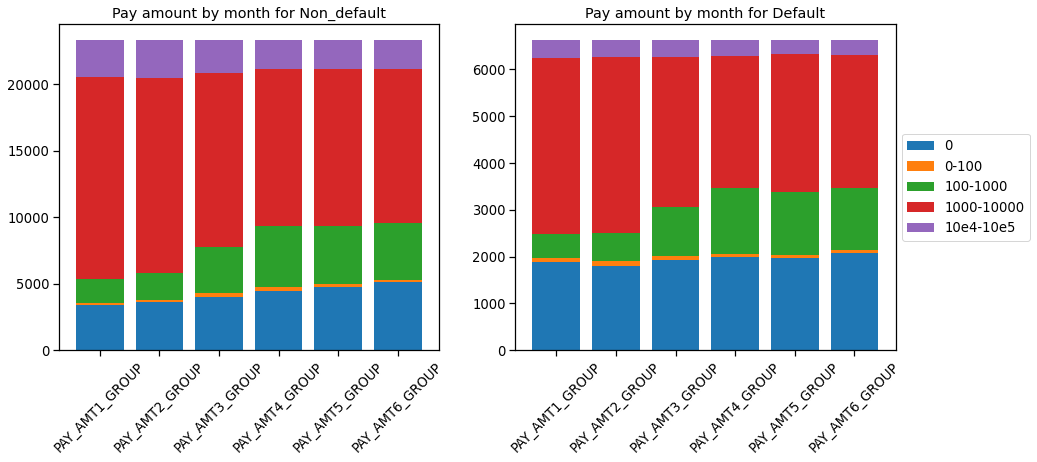

In [26]:
f, axes = plt.subplots(1, 2, figsize=(15, 6), facecolor='white')
plt.style.use('seaborn-deep')

for i in range(5):
    axes[0].bar(column_to_count, pay_amt_count.loc[0].iloc[i], bottom=pay_amt_count.loc[0].iloc[:i].sum())
    axes[1].bar(column_to_count, pay_amt_count.loc[1].iloc[i], bottom=pay_amt_count.loc[1].iloc[:i].sum())
    
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45)
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45)
axes[0].set_title('Pay amount by month for Non_default')
axes[1].set_title('Pay amount by month for Default')

plt.legend(['0','0-100', '100-1000', '1000-10000', '10e4-10e5'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


<font color = red> Observations: For those who did not default, there are much higher counts of paying $0 for their bills

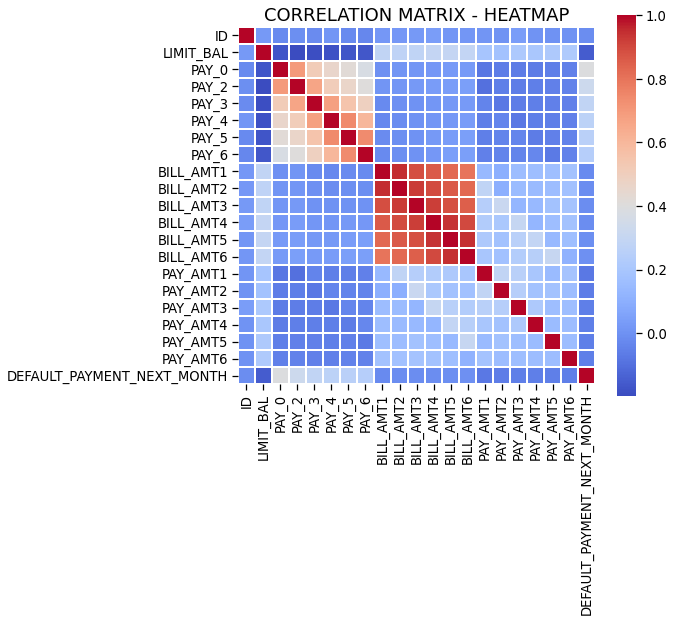

In [27]:
corr = df.corr() # .corr is used to find corelation
f,ax = plt.subplots(figsize=(8, 7))
sns.heatmap(corr, cbar = True,  square = True, annot = False, fmt= '.1f', xticklabels= True, yticklabels= True,cmap="coolwarm", linewidths=.5, ax=ax)
plt.title('CORRELATION MATRIX - HEATMAP', size=18);

<font color = red> Observations: Higher correlations found between PAY_X variables and highest correlations found between BILL_AMTX variables

In [28]:
#check the outcome variable
df[['DEFAULT_PAYMENT_NEXT_MONTH']].describe()

,DEFAULT_PAYMENT_NEXT_MONTH
count,30000.000
mean,0.221
std,0.415
min,0.000
25%,0.000
50%,0.000
75%,0.000
max,1.000


In [29]:
df['DEFAULT_PAYMENT_NEXT_MONTH'].value_counts()

0    23364
1     6636
Name: DEFAULT_PAYMENT_NEXT_MONTH, dtype: int64

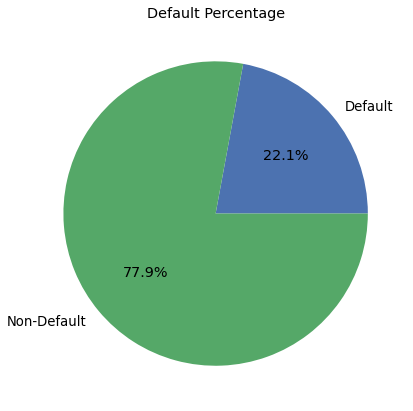

In [30]:
# Percentage default
no_default = df.DEFAULT_PAYMENT_NEXT_MONTH.sum()
no_non_default = len(df)-no_default
perc_default = round(no_default/len(df)*100, 1)
perc_non_default = round(no_non_default/len(df)*100, 1)

fig=plt.figure(figsize=(10, 7))
labels=['Default','Non-Default']
values=[perc_default, perc_non_default]
plt.pie(values,labels=labels,autopct='%1.1f%%')
plt.title("Default Percentage")
plt.show()

<font color = red>about 22% of the sample defaulted their payment

In [31]:
#rename columns for easier identification

df.rename(columns={'PAY_0': 'REPAYMENT_SEP', 'PAY_2': 'REPAYMENT_AUG', 'PAY_3':'REPAYMENT_JUL', 'PAY_4':'REPAYMENT_JUN', 'PAY_5':'REPAYMENT_MAY', 'PAY_6':'REPAYMENT_APR',
                  'BILL_AMT1':'BILL_AMT_SEP', 'BILL_AMT2':'BILL_AMT_AUG','BILL_AMT3':'BILL_AMT_JUL','BILL_AMT4':'BILL_AMT_JUN','BILL_AMT5':'BILL_AMT_MAY','BILL_AMT6':'BILL_AMT_APR',
                  'PAY_AMT1':'AMT_PAID_SEP','PAY_AMT2':'AMT_PAID_AUG','PAY_AMT3':'AMT_PAID_JUL','PAY_AMT4':'AMT_PAID_JUN','PAY_AMT5':'AMT_PAID_MAY','PAY_AMT6':'AMT_PAID_APR'}, inplace=True)


In [32]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,REPAYMENT_SEP,REPAYMENT_AUG,REPAYMENT_JUL,REPAYMENT_JUN,REPAYMENT_MAY,REPAYMENT_APR,BILL_AMT_SEP,BILL_AMT_AUG,BILL_AMT_JUL,BILL_AMT_JUN,BILL_AMT_MAY,BILL_AMT_APR,AMT_PAID_SEP,AMT_PAID_AUG,AMT_PAID_JUL,AMT_PAID_JUN,AMT_PAID_MAY,AMT_PAID_APR,DEFAULT_PAYMENT_NEXT_MONTH,AGE_GROUP
0,1,20000,FEMALE,UNIVERSITY,MARRIED,2,2,0,0,0,0,3913,3102,689,0,0,0,0,689,0,0,0,0,1,20s
1,2,120000,FEMALE,UNIVERSITY,SINGLE,0,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,20s
2,3,90000,FEMALE,UNIVERSITY,SINGLE,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,30s
3,4,50000,FEMALE,UNIVERSITY,MARRIED,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,30s
4,5,50000,MALE,UNIVERSITY,MARRIED,0,0,0,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,50s


# 2.2 ONE HOT ENCODING - renaming to df2 so as to save df for Cat Boost

In [33]:
#One Hot Encoding for all the categorical variables


df2 = pd.get_dummies(df, columns=['AGE_GROUP','SEX','EDUCATION','MARRIAGE'], prefix={'AGE_GROUP':'AGE_GROUP','SEX': 'SEX', 'EDUCATION': 'EDUCATION','MARRIAGE':'MARRIAGE'})

In [34]:
df2.head()

,ID,LIMIT_BAL,REPAYMENT_SEP,REPAYMENT_AUG,REPAYMENT_JUL,REPAYMENT_JUN,REPAYMENT_MAY,REPAYMENT_APR,BILL_AMT_SEP,BILL_AMT_AUG,BILL_AMT_JUL,BILL_AMT_JUN,BILL_AMT_MAY,BILL_AMT_APR,AMT_PAID_SEP,AMT_PAID_AUG,AMT_PAID_JUL,AMT_PAID_JUN,AMT_PAID_MAY,AMT_PAID_APR,DEFAULT_PAYMENT_NEXT_MONTH,AGE_GROUP_20s,AGE_GROUP_30s,AGE_GROUP_40s,AGE_GROUP_50s,AGE_GROUP_60s,AGE_GROUP_70s,SEX_FEMALE,SEX_MALE,EDUCATION_GRADUATE_SCHOOL,EDUCATION_HIGH_SCHOOL,EDUCATION_OTHERS,EDUCATION_UNIVERSITY,EDUCATION_UNKNOWN,MARRIAGE_MARRIED,MARRIAGE_OTHERS,MARRIAGE_SINGLE,MARRIAGE_UNKNOWN
0,1,20000,2,2,0,0,0,0,3913,3102,689,0,0,0,0,689,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0
1,2,120000,0,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0
2,3,90000,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0
3,4,50000,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0
4,5,50000,0,0,0,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0


# 3. Prepare data for analysis

In [35]:
featurelist = df2.drop(['ID','DEFAULT_PAYMENT_NEXT_MONTH'],axis = 1)
featurelist.head()

,LIMIT_BAL,REPAYMENT_SEP,REPAYMENT_AUG,REPAYMENT_JUL,REPAYMENT_JUN,REPAYMENT_MAY,REPAYMENT_APR,BILL_AMT_SEP,BILL_AMT_AUG,BILL_AMT_JUL,BILL_AMT_JUN,BILL_AMT_MAY,BILL_AMT_APR,AMT_PAID_SEP,AMT_PAID_AUG,AMT_PAID_JUL,AMT_PAID_JUN,AMT_PAID_MAY,AMT_PAID_APR,AGE_GROUP_20s,AGE_GROUP_30s,AGE_GROUP_40s,AGE_GROUP_50s,AGE_GROUP_60s,AGE_GROUP_70s,SEX_FEMALE,SEX_MALE,EDUCATION_GRADUATE_SCHOOL,EDUCATION_HIGH_SCHOOL,EDUCATION_OTHERS,EDUCATION_UNIVERSITY,EDUCATION_UNKNOWN,MARRIAGE_MARRIED,MARRIAGE_OTHERS,MARRIAGE_SINGLE,MARRIAGE_UNKNOWN
0,20000,2,2,0,0,0,0,3913,3102,689,0,0,0,0,689,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0
1,120000,0,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0
2,90000,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0
3,50000,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0
4,50000,0,0,0,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0


# 3.1 Define X and y and train test split

In [36]:
# Set up X and y variables and split data for training and testing

X = featurelist
y = df2['DEFAULT_PAYMENT_NEXT_MONTH']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [37]:
#standardscaler is only applied to the continuous variables and NOT the one-hot-encoded variables

from sklearn.compose import ColumnTransformer

ct = ColumnTransformer([('X_train', StandardScaler(), ['LIMIT_BAL','REPAYMENT_SEP','REPAYMENT_AUG','REPAYMENT_JUL','REPAYMENT_JUN','REPAYMENT_MAY','REPAYMENT_APR','BILL_AMT_SEP','BILL_AMT_AUG',
                                                        'BILL_AMT_JUL','BILL_AMT_JUN','BILL_AMT_MAY','BILL_AMT_APR','AMT_PAID_SEP','AMT_PAID_AUG','AMT_PAID_JUL','AMT_PAID_JUN','AMT_PAID_MAY',
                                                        'AMT_PAID_APR'])], remainder ='passthrough')

X_train_scaled = ct.fit_transform(X_train)
X_test_scaled = ct.transform(X_test)

# 3.2 Logistic Regression

In [38]:
# Grid search cross validation
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

#create parameter grid
grid={'C':np.logspace(-3,3,7), 'penalty':['l1','l2'], 'solver':['liblinear']}# l1 lasso l2 ridge

logreg = LogisticRegression()

#create logistic regression classifier with gridsearch CV

logreg_classifier = GridSearchCV(logreg, grid, cv=5)

logreg_classifier.fit(X_train_scaled,y_train)

print("tuned parameters :(best parameters) ",logreg_classifier.best_params_)
print("accuracy :",logreg_classifier.best_score_)

tuned parameters :(best parameters)  {'C': 10.0, 'penalty': 'l1', 'solver': 'liblinear'}
accuracy : 0.8189166666666667


Model Accuracy: 0.8163333333333334

              precision    recall  f1-score   support

           0       0.83      0.95      0.89      4687
           1       0.67      0.32      0.43      1313

    accuracy                           0.82      6000
   macro avg       0.75      0.64      0.66      6000
weighted avg       0.80      0.82      0.79      6000


Average 5-Fold CV Score: 0.8173 , Standard deviation: 0.009


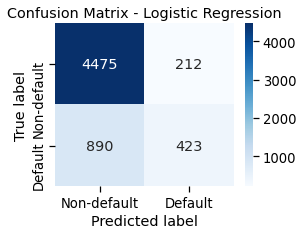

In [39]:
#create a classifier with best params based on grid search
best_logreg = LogisticRegression(C=10.0, penalty = 'l1', solver = 'liblinear', random_state=24)

#fit the model with training data and predict on the testing data
best_logreg.fit(X_train_scaled, y_train)
y_pred = best_logreg.predict(X_test_scaled)

print('Model Accuracy:', metrics.accuracy_score(y_pred,y_test))

## 5-fold cross-validation 
cv_scores =cross_val_score(best_logreg, X, y, cv=5)

# Print the 5-fold cross-validation scores
print()
print(classification_report(y_test, y_pred))
print()
print("Average 5-Fold CV Score: {}".format(round(np.mean(cv_scores),4)),
      ", Standard deviation: {}".format(round(np.std(cv_scores),4)))

plt.figure(figsize=(4,3))
ConfMatrix = confusion_matrix(y_test,best_logreg.predict(X_test_scaled))
sns.heatmap(ConfMatrix,annot=True, cmap="Blues", fmt="d", 
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - Logistic Regression");

In [40]:
#look at intercept and coefficients
print("Log Reg Intercept is: %s" % best_logreg.intercept_)


Log Reg Intercept is: [-0.00472914]


In [41]:
#print coefficient scores with feature names
coefficients = pd.DataFrame({"Feature":X.columns,"Coefficients":np.transpose(best_logreg.coef_[0])}) 
coefficients.sort_values('Coefficients')

,Feature,Coefficients
31,EDUCATION_UNKNOWN,-1.933
29,EDUCATION_OTHERS,-1.718
35,MARRIAGE_UNKNOWN,-1.493
28,EDUCATION_HIGH_SCHOOL,-0.891
30,EDUCATION_UNIVERSITY,-0.837
27,EDUCATION_GRADUATE_SCHOOL,-0.833
25,SEX_FEMALE,-0.463
26,SEX_MALE,-0.332
14,AMT_PAID_AUG,-0.222
0,LIMIT_BAL,-0.192


In [42]:
#use the logistic regression model to predict probabilities (of 0 and 1) for each row of the testing data
logregprob = best_logreg.predict_proba(X_test_scaled)

#put the predicted probabilities into a dataframe
#For probability values, first value is probability of outcome = 0, second value is probability of outcome = 1

logregpredprob = pd.DataFrame({"probabilities":list(logregprob)})




In [43]:
#Create a X_test df using the X_test data to store the probability values
X_testdf = pd.DataFrame(X_test, columns = X.columns)

#insert a column to store the logistic regression probability values
X_testdf['LOGREGPROBABILITIES'] = logregpredprob.values




In [44]:
#create 2 new columns with probability of non-default and default, and drop the logregprobabilities column
X_testdf[['LR_PROB_NONDEFAULT','LR_PROB_DEFAULT']] = pd.DataFrame(X_testdf.LOGREGPROBABILITIES.values.tolist(), index= X_testdf.index)
X_testdf.drop(['LOGREGPROBABILITIES'], axis = 1, inplace = True)


In [45]:
X_testdf.head()

,LIMIT_BAL,REPAYMENT_SEP,REPAYMENT_AUG,REPAYMENT_JUL,REPAYMENT_JUN,REPAYMENT_MAY,REPAYMENT_APR,BILL_AMT_SEP,BILL_AMT_AUG,BILL_AMT_JUL,BILL_AMT_JUN,BILL_AMT_MAY,BILL_AMT_APR,AMT_PAID_SEP,AMT_PAID_AUG,AMT_PAID_JUL,AMT_PAID_JUN,AMT_PAID_MAY,AMT_PAID_APR,AGE_GROUP_20s,AGE_GROUP_30s,AGE_GROUP_40s,AGE_GROUP_50s,AGE_GROUP_60s,AGE_GROUP_70s,SEX_FEMALE,SEX_MALE,EDUCATION_GRADUATE_SCHOOL,EDUCATION_HIGH_SCHOOL,EDUCATION_OTHERS,EDUCATION_UNIVERSITY,EDUCATION_UNKNOWN,MARRIAGE_MARRIED,MARRIAGE_OTHERS,MARRIAGE_SINGLE,MARRIAGE_UNKNOWN,LR_PROB_NONDEFAULT,LR_PROB_DEFAULT
2308,30000,0,0,0,0,0,0,8864,10062,11581,12580,13716,14828,1500,2000,1500,1500,1500,2000,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0.836,0.164
22404,150000,0,0,0,0,0,0,136736,125651,116684,101581,77741,77264,4486,4235,3161,2647,2669,2669,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0.871,0.129
23397,70000,0,0,0,0,0,0,70122,69080,68530,69753,70111,70212,2431,3112,3000,2438,2500,2554,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0.842,0.158
25058,130000,0,0,0,0,0,0,20678,18956,16172,16898,11236,6944,1610,1808,7014,27,7011,4408,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0.852,0.148
2664,50000,0,0,0,0,0,2,94228,47635,42361,19574,20295,19439,2000,1500,1000,1800,0,1000,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0.815,0.185


# 3.3 Random Forest Classifier

In [46]:
# Create the parameter grid

rf = RandomForestClassifier(random_state=42)

param_grid = { 
    'n_estimators': [100, 200, 500],
    'max_features': ['auto', 'sqrt'],
    'max_depth' : [4,5,6,7,8,9],
    'criterion' :['gini', 'entropy']
}

#run the classifier using gridsearch and fit the model using training data
rf_classifier = GridSearchCV(estimator=rf, param_grid=param_grid, cv = 5, n_jobs = -1, verbose = 10)

rf_classifier.fit(X_train_scaled, y_train)

print("Tuned Random Forest Parameters: %s" % (rf_classifier.best_params_))

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   51.6s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5

Tuned Random Forest Parameters: {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 500}


Accuracy: 0.8203333333333334

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4687
           1       0.67      0.35      0.46      1313

    accuracy                           0.82      6000
   macro avg       0.76      0.65      0.68      6000
weighted avg       0.80      0.82      0.80      6000


Average 5-Fold CV Score: 0.8203 Standard deviation: 0.0096


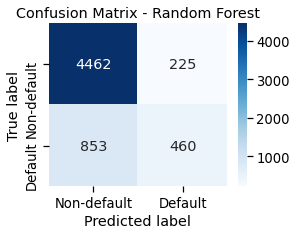

In [47]:
#using the best parameters to train the rf model

best_rf = RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 500, max_depth=8, criterion='entropy')

best_rf.fit(X_train_scaled, y_train)

y_pred = best_rf.predict(X_test_scaled)

print('Accuracy:', metrics.accuracy_score(y_pred,y_test))

## 5-fold cross-validation 
cv_scores =cross_val_score(best_rf, X, y, cv=5)

# Print the 5-fold cross-validation scores
print()
print(classification_report(y_test, y_pred))
print()
print("Average 5-Fold CV Score: {}".format(round(np.mean(cv_scores),4)),"Standard deviation: {}".format(round(np.std(cv_scores),4)))

#plot the confusion matrix
plt.figure(figsize=(4,3))
ConfMatrix = confusion_matrix(y_test,best_rf.predict(X_test_scaled))
sns.heatmap(ConfMatrix,annot=True, cmap="Blues", fmt="d", 
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - Random Forest");


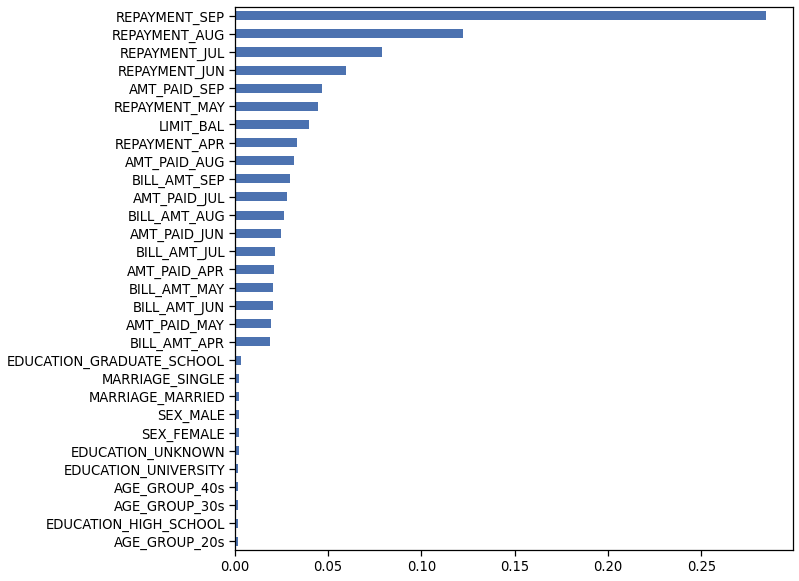

In [48]:
#look at the most important features based on the best rf model
fig, (ax) = plt.subplots(ncols=1, figsize=(10,10))

rf_feat_importances = pd.Series(best_rf.feature_importances_, index=X.columns)

rf_feat_importances.nlargest(30).sort_values(ascending=True).plot(kind='barh')
plt.show()

In [49]:
#use the Random Forest Classifier model to predict probabilities (of 0 and 1) for each row of the testing data
rfprob = best_rf.predict_proba(X_test_scaled)

#put the predicted probabilities into a dataframe
#For probability values, first value is probability of outcome = 0, second value is probability of outcome = 1

rfpredprob = pd.DataFrame({"probabilities":list(rfprob)})

In [50]:
#insert a column to store the random forest classifier probability values
X_testdf['RFPROBABILITIES'] = rfpredprob.values

In [51]:
#create 2 new columns with probability of non-default and default, and drop the xgbprobabilities column
X_testdf[['RF_PROB_NONDEFAULT','RF_PROB_DEFAULT']] = pd.DataFrame(X_testdf.RFPROBABILITIES.values.tolist(), index= X_testdf.index)
X_testdf.drop(['RFPROBABILITIES'], axis = 1, inplace=True)


In [52]:
X_testdf.head()

,LIMIT_BAL,REPAYMENT_SEP,REPAYMENT_AUG,REPAYMENT_JUL,REPAYMENT_JUN,REPAYMENT_MAY,REPAYMENT_APR,BILL_AMT_SEP,BILL_AMT_AUG,BILL_AMT_JUL,BILL_AMT_JUN,BILL_AMT_MAY,BILL_AMT_APR,AMT_PAID_SEP,AMT_PAID_AUG,AMT_PAID_JUL,AMT_PAID_JUN,AMT_PAID_MAY,AMT_PAID_APR,AGE_GROUP_20s,AGE_GROUP_30s,AGE_GROUP_40s,AGE_GROUP_50s,AGE_GROUP_60s,AGE_GROUP_70s,SEX_FEMALE,SEX_MALE,EDUCATION_GRADUATE_SCHOOL,EDUCATION_HIGH_SCHOOL,EDUCATION_OTHERS,EDUCATION_UNIVERSITY,EDUCATION_UNKNOWN,MARRIAGE_MARRIED,MARRIAGE_OTHERS,MARRIAGE_SINGLE,MARRIAGE_UNKNOWN,LR_PROB_NONDEFAULT,LR_PROB_DEFAULT,RF_PROB_NONDEFAULT,RF_PROB_DEFAULT
2308,30000,0,0,0,0,0,0,8864,10062,11581,12580,13716,14828,1500,2000,1500,1500,1500,2000,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0.836,0.164,0.840,0.160
22404,150000,0,0,0,0,0,0,136736,125651,116684,101581,77741,77264,4486,4235,3161,2647,2669,2669,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0.871,0.129,0.913,0.087
23397,70000,0,0,0,0,0,0,70122,69080,68530,69753,70111,70212,2431,3112,3000,2438,2500,2554,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0.842,0.158,0.879,0.121
25058,130000,0,0,0,0,0,0,20678,18956,16172,16898,11236,6944,1610,1808,7014,27,7011,4408,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0.852,0.148,0.886,0.114
2664,50000,0,0,0,0,0,2,94228,47635,42361,19574,20295,19439,2000,1500,1000,1800,0,1000,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0.815,0.185,0.810,0.190


# 3.4 XGBoost classifier

In [47]:
# Create the parameter grid
xgb = XGBClassifier(objective = 'binary:logistic') 

param_grid = [{'max_depth': range(4,10,2), 'n_estimators':[100,500], 'eta':[0.01,0.1], 'colsample_bytree':[0.8,1], 'subsample':[0.8,1] }]

#create svm classifier
xgb_classifier = GridSearchCV(xgb, param_grid, cv = 5, refit = True, verbose = 10, scoring = 'roc_auc', n_jobs=-1) 


# fitting the model for grid search 
xgb_classifier.fit(X_train_scaled, y_train) 

print("Tuned XGB Parameters: %s" % (xgb_classifier.best_params_))

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   50.4s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 12

Tuned XGB Parameters: {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 6, 'n_estimators': 500, 'subsample': 0.8}


Accuracy: 0.8213333333333334

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4687
           1       0.67      0.36      0.47      1313

    accuracy                           0.82      6000
   macro avg       0.76      0.65      0.68      6000
weighted avg       0.80      0.82      0.80      6000


Average 5-Fold CV Score: 0.821 Standard deviation: 0.0099


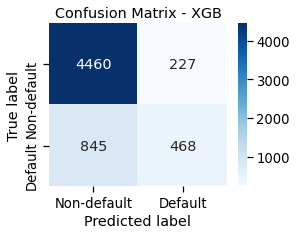

In [53]:
#using the best parameters to train the xgb model

best_xgb = XGBClassifier(max_depth=6, n_estimators=500, eta = 0.01, colsample_bytree = 0.8, subsample = 0.8, verbose = True)

best_xgb.fit(X_train_scaled, y_train)

y_pred = best_xgb.predict(X_test_scaled)

print('Accuracy:', metrics.accuracy_score(y_pred,y_test))

## 5-fold cross-validation 
cv_scores =cross_val_score(best_xgb, X, y, cv=5)

# Print the 5-fold cross-validation scores
print()
print(classification_report(y_test, y_pred))
print()
print("Average 5-Fold CV Score: {}".format(round(np.mean(cv_scores),4)),"Standard deviation: {}".format(round(np.std(cv_scores),4)))

#plot the confusion matrix
plt.figure(figsize=(4,3))
ConfMatrix = confusion_matrix(y_test,best_xgb.predict(X_test_scaled))
sns.heatmap(ConfMatrix,annot=True, cmap="Blues", fmt="d", 
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - XGB");


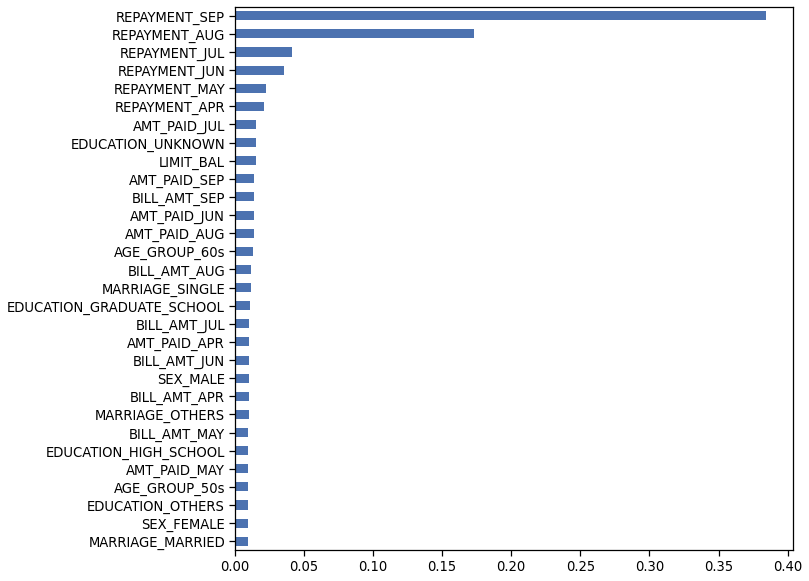

In [54]:
#look at the most important features based on the best xgb model

fig, (ax) = plt.subplots(ncols=1, figsize=(10,10))

xgb_feat_importances = pd.Series(best_xgb.feature_importances_, index=X.columns)

xgb_feat_importances.nlargest(30).sort_values(ascending=True).plot(kind='barh')
plt.show()

In [55]:
#use the XG Boost Classifier model to predict probabilities (of 0 and 1) for each row of the testing data
xgbprob = best_xgb.predict_proba(X_test_scaled)

#put the predicted probabilities into a dataframe
#For probability values, first value is probability of outcome = 0, second value is probability of outcome = 1

xgbpredprob = pd.DataFrame({"probabilities":list(xgbprob)})

In [56]:
#insert a column to store the XG Boost probability values
X_testdf['XGBPROBABILITIES'] = xgbpredprob.values

In [57]:
#create 2 new columns with probability of non-default and default, and drop the xgbprobabilities column
X_testdf[['XGB_PROB_NONDEFAULT','XGB_PROB_DEFAULT']] = pd.DataFrame(X_testdf.XGBPROBABILITIES.values.tolist(), index= X_testdf.index)
X_testdf.drop(['XGBPROBABILITIES'], axis = 1, inplace=True)

In [58]:
X_testdf.head()

,LIMIT_BAL,REPAYMENT_SEP,REPAYMENT_AUG,REPAYMENT_JUL,REPAYMENT_JUN,REPAYMENT_MAY,REPAYMENT_APR,BILL_AMT_SEP,BILL_AMT_AUG,BILL_AMT_JUL,BILL_AMT_JUN,BILL_AMT_MAY,BILL_AMT_APR,AMT_PAID_SEP,AMT_PAID_AUG,AMT_PAID_JUL,AMT_PAID_JUN,AMT_PAID_MAY,AMT_PAID_APR,AGE_GROUP_20s,AGE_GROUP_30s,AGE_GROUP_40s,AGE_GROUP_50s,AGE_GROUP_60s,AGE_GROUP_70s,SEX_FEMALE,SEX_MALE,EDUCATION_GRADUATE_SCHOOL,EDUCATION_HIGH_SCHOOL,EDUCATION_OTHERS,EDUCATION_UNIVERSITY,EDUCATION_UNKNOWN,MARRIAGE_MARRIED,MARRIAGE_OTHERS,MARRIAGE_SINGLE,MARRIAGE_UNKNOWN,LR_PROB_NONDEFAULT,LR_PROB_DEFAULT,RF_PROB_NONDEFAULT,RF_PROB_DEFAULT,XGB_PROB_NONDEFAULT,XGB_PROB_DEFAULT
2308,30000,0,0,0,0,0,0,8864,10062,11581,12580,13716,14828,1500,2000,1500,1500,1500,2000,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0.836,0.164,0.840,0.160,0.827,0.173
22404,150000,0,0,0,0,0,0,136736,125651,116684,101581,77741,77264,4486,4235,3161,2647,2669,2669,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0.871,0.129,0.913,0.087,0.912,0.088
23397,70000,0,0,0,0,0,0,70122,69080,68530,69753,70111,70212,2431,3112,3000,2438,2500,2554,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0.842,0.158,0.879,0.121,0.859,0.141
25058,130000,0,0,0,0,0,0,20678,18956,16172,16898,11236,6944,1610,1808,7014,27,7011,4408,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0.852,0.148,0.886,0.114,0.905,0.095
2664,50000,0,0,0,0,0,2,94228,47635,42361,19574,20295,19439,2000,1500,1000,1800,0,1000,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0.815,0.185,0.810,0.190,0.802,0.198


# 3.5 Light GBM

In [54]:
# Build LightGBMclassifier
lgb = LGBMClassifier(objective = 'binary')

# create parameter grid

param_grid = [{'learning_rate': (0.005,0.1),'n_estimators':range(200, 500,100), 'num_leaves':range(20,60,10), 'max_bin': [512], 'eta':[0.01,0.1], 'colsample_bytree':[0.8,1], 'subsample':[0.8,1]}]

lgb_classifier = GridSearchCV(lgb, param_grid, cv = 5, scoring= 'roc_auc', n_jobs=-1, verbose = 10)


lgb_classifier.fit(X_train_scaled,y_train)

print("Tuned LGBM Parameters: %s" % (lgb_classifier.best_params_))

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   43.7s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   56.0s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2

Tuned LGBM Parameters: {'colsample_bytree': 0.8, 'eta': 0.01, 'learning_rate': 0.005, 'max_bin': 512, 'n_estimators': 400, 'num_leaves': 40, 'subsample': 0.8}


Accuracy: 0.8176666666666667

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4687
           1       0.67      0.33      0.44      1313

    accuracy                           0.82      6000
   macro avg       0.75      0.64      0.67      6000
weighted avg       0.80      0.82      0.79      6000


Average 5-Fold CV Score: 0.8169 Standard deviation: 0.0094


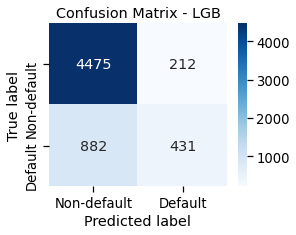

In [59]:
#using the best parameters to train the lgb model

best_lgb = LGBMClassifier(n_estimators = 400, num_leaves=400, eta = 0.01, colsample_bytree = 0.8, subsample = 0.8, learning_rate = 0.005, max_bin = 512, verbose = 10)

best_lgb.fit(X_train_scaled, y_train)

y_pred = best_lgb.predict(X_test_scaled)

# CV score
lgb_cv=cross_val_score(best_lgb, X, y, cv=5)

print('Accuracy:', metrics.accuracy_score(y_pred,y_test))

# Print the 5-fold cross-validation scores
print()
print(classification_report(y_test, y_pred))
print()
print("Average 5-Fold CV Score: {}".format(round(np.mean(lgb_cv),4)),"Standard deviation: {}".format(round(np.std(lgb_cv),4)))

#plot the confusion matrix
plt.figure(figsize=(4,3))
ConfMatrix = confusion_matrix(y_test,best_lgb.predict(X_test_scaled))
sns.heatmap(ConfMatrix,annot=True, cmap="Blues", fmt="d", 
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - LGB");

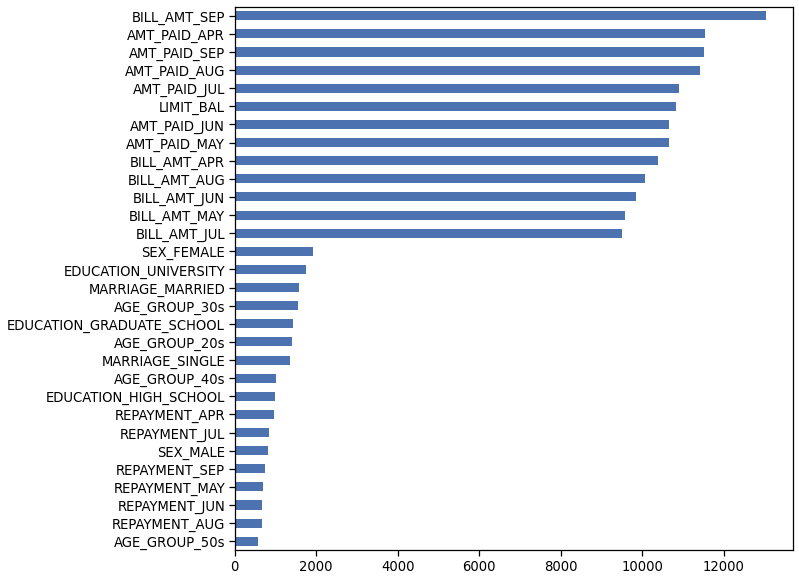

In [60]:
#look at the most important features based on the best lgb model

fig, (ax) = plt.subplots(ncols=1, figsize=(10,10))

lgb_feat_importances = pd.Series(best_lgb.feature_importances_, index=X.columns)

lgb_feat_importances.nlargest(30).sort_values(ascending=True).plot(kind='barh')
plt.show()

In [61]:
#use the Light GBM Classifier model to predict probabilities (of 0 and 1) for each row of the testing data
lgbprob = best_lgb.predict_proba(X_test_scaled)

#put the predicted probabilities into a dataframe
#For probability values, first value is probability of outcome = 0, second value is probability of outcome = 1

lgbpredprob = pd.DataFrame({"probabilities":list(lgbprob)})

In [62]:
#insert a column to store the LGBM probability values
X_testdf['LGBMPROBABILITIES'] = lgbpredprob.values

In [63]:
#create 2 new columns with probability of non-default and default, and drop the xgbprobabilities column
X_testdf[['LGBM_PROB_NONDEFAULT','LGBM_PROB_DEFAULT']] = pd.DataFrame(X_testdf.LGBMPROBABILITIES.values.tolist(), index= X_testdf.index)
X_testdf.drop(['LGBMPROBABILITIES'], axis = 1, inplace=True)

In [64]:
X_testdf.head()

,LIMIT_BAL,REPAYMENT_SEP,REPAYMENT_AUG,REPAYMENT_JUL,REPAYMENT_JUN,REPAYMENT_MAY,REPAYMENT_APR,BILL_AMT_SEP,BILL_AMT_AUG,BILL_AMT_JUL,BILL_AMT_JUN,BILL_AMT_MAY,BILL_AMT_APR,AMT_PAID_SEP,AMT_PAID_AUG,AMT_PAID_JUL,AMT_PAID_JUN,AMT_PAID_MAY,AMT_PAID_APR,AGE_GROUP_20s,AGE_GROUP_30s,AGE_GROUP_40s,AGE_GROUP_50s,AGE_GROUP_60s,AGE_GROUP_70s,SEX_FEMALE,SEX_MALE,EDUCATION_GRADUATE_SCHOOL,EDUCATION_HIGH_SCHOOL,EDUCATION_OTHERS,EDUCATION_UNIVERSITY,EDUCATION_UNKNOWN,MARRIAGE_MARRIED,MARRIAGE_OTHERS,MARRIAGE_SINGLE,MARRIAGE_UNKNOWN,LR_PROB_NONDEFAULT,LR_PROB_DEFAULT,RF_PROB_NONDEFAULT,RF_PROB_DEFAULT,XGB_PROB_NONDEFAULT,XGB_PROB_DEFAULT,LGBM_PROB_NONDEFAULT,LGBM_PROB_DEFAULT
2308,30000,0,0,0,0,0,0,8864,10062,11581,12580,13716,14828,1500,2000,1500,1500,1500,2000,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0.836,0.164,0.840,0.160,0.827,0.173,0.768,0.232
22404,150000,0,0,0,0,0,0,136736,125651,116684,101581,77741,77264,4486,4235,3161,2647,2669,2669,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0.871,0.129,0.913,0.087,0.912,0.088,0.894,0.106
23397,70000,0,0,0,0,0,0,70122,69080,68530,69753,70111,70212,2431,3112,3000,2438,2500,2554,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0.842,0.158,0.879,0.121,0.859,0.141,0.796,0.204
25058,130000,0,0,0,0,0,0,20678,18956,16172,16898,11236,6944,1610,1808,7014,27,7011,4408,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0.852,0.148,0.886,0.114,0.905,0.095,0.910,0.090
2664,50000,0,0,0,0,0,2,94228,47635,42361,19574,20295,19439,2000,1500,1000,1800,0,1000,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0.815,0.185,0.810,0.190,0.802,0.198,0.819,0.181


# 3.6 CAT Boost

# Using df here as Cat Boost does not allow one hot encoded variables as categories, variables have to be categorical and string

In [65]:
X_cb = df.drop(['ID','DEFAULT_PAYMENT_NEXT_MONTH'],axis = 1)
y_cb = df['DEFAULT_PAYMENT_NEXT_MONTH']

In [66]:
X_cb.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,REPAYMENT_SEP,REPAYMENT_AUG,REPAYMENT_JUL,REPAYMENT_JUN,REPAYMENT_MAY,REPAYMENT_APR,BILL_AMT_SEP,BILL_AMT_AUG,BILL_AMT_JUL,BILL_AMT_JUN,BILL_AMT_MAY,BILL_AMT_APR,AMT_PAID_SEP,AMT_PAID_AUG,AMT_PAID_JUL,AMT_PAID_JUN,AMT_PAID_MAY,AMT_PAID_APR,AGE_GROUP
0,20000,FEMALE,UNIVERSITY,MARRIED,2,2,0,0,0,0,3913,3102,689,0,0,0,0,689,0,0,0,0,20s
1,120000,FEMALE,UNIVERSITY,SINGLE,0,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,20s
2,90000,FEMALE,UNIVERSITY,SINGLE,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,30s
3,50000,FEMALE,UNIVERSITY,MARRIED,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,30s
4,50000,MALE,UNIVERSITY,MARRIED,0,0,0,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,50s


In [67]:
#spilt data
X_train_cb, X_test_cb, y_train_cb, y_test_cb = train_test_split(X_cb, y_cb, train_size=0.80, random_state=42)

print("Shape of X_train = ", X_train_cb.shape)
print("Shape of X_test = ", X_test_cb.shape)

Shape of X_train =  (24000, 23)
Shape of X_test =  (6000, 23)


In [68]:
#the catboost model does not work with scaled numerical figures. Throws error. Catboost treats all the data as string.

# #standardscaler is only applied to the continuous variables and NOT the categorical variable

# ct_cb = ColumnTransformer([('X_train_cb', StandardScaler(), ['LIMIT_BAL','REPAYMENT_SEP','REPAYMENT_AUG','REPAYMENT_JUL','REPAYMENT_JUN','REPAYMENT_MAY','REPAYMENT_APR','BILL_AMT_SEP','BILL_AMT_AUG',
#                                                         'BILL_AMT_JUL','BILL_AMT_JUN','BILL_AMT_MAY','BILL_AMT_APR','AMT_PAID_SEP','AMT_PAID_AUG','AMT_PAID_JUL','AMT_PAID_JUN','AMT_PAID_MAY',
#                                                         'AMT_PAID_APR'])], remainder ='passthrough')

# X_train_cb_scaled = ct_cb.fit_transform(X_train_cb)
# X_test_cb_scaled = ct_cb.transform(X_test_cb)

catbost classifier 

In [69]:
# X has categorical columns
categorical_features_indices = np.where(X_cb.dtypes != np.int64)[0]
categorical_features_indices

array([ 1,  2,  3, 22], dtype=int64)

In [70]:
# Create the parameter grid

model = CatBoostClassifier(random_seed=42, cat_features = categorical_features_indices)
parameters = {'depth' : [6,8,10],
'learning_rate' : [0.01, 0.05, 0.1],
'iterations' : [30, 50, 100]
}

#run the classifier using gridsearch and fit the model using training data
cb_classifier = GridSearchCV(estimator=model, param_grid=parameters, cv = 5, n_jobs = -1, verbose = 10)

cb_classifier.fit(X_train_cb, y_train_cb, silent=True)

print("Tuned Catboost Parameters: %s" % (cb_classifier.best_params_))

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   52.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:  7.5min finished


Tuned Catboost Parameters: {'depth': 6, 'iterations': 100, 'learning_rate': 0.05}


In [70]:
#using the best parameters to train the catboost model

best_cb = CatBoostClassifier(depth = 6, iterations = 50, learning_rate=0.05, eval_metric='Accuracy', loss_function='Logloss')
best_cb.fit(X_train_cb, y_train_cb, cat_features=categorical_features_indices, silent=True)
pred = best_cb.predict(X_test_cb)

#Calculating the Accuracy Score
accuracy = metrics.accuracy_score(pred, y_test_cb)

print("Accuracy of Catboost model = ", accuracy)

Accuracy of Catboost model =  0.821


Classification report for Catboost Regressor:


              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4687
           1       0.67      0.36      0.47      1313

    accuracy                           0.82      6000
   macro avg       0.76      0.65      0.68      6000
weighted avg       0.80      0.82      0.80      6000



Accuracy of Catboost model =  0.821


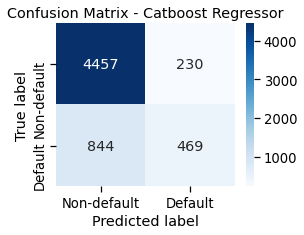

In [71]:
#Creating classification reports and confusion matrix
print("Classification report for Catboost Regressor:")
print("\n")

class_report_catboost = classification_report(y_test_cb, pred)
print(class_report_catboost)
print("\n")

#plot the confusion matrix
plt.figure(figsize=(4,3))

ConfMatrix = confusion_matrix(y_test_cb ,best_cb.predict(X_test_cb))
sns.heatmap(ConfMatrix,annot=True, cmap="Blues", fmt="d", 
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - Catboost Regressor");

print("Accuracy of Catboost model = ", (ConfMatrix[0][0]+ConfMatrix[1][1])/(ConfMatrix[0][0]+ConfMatrix[1][1]+ConfMatrix[0][1]+ConfMatrix[1][0]))

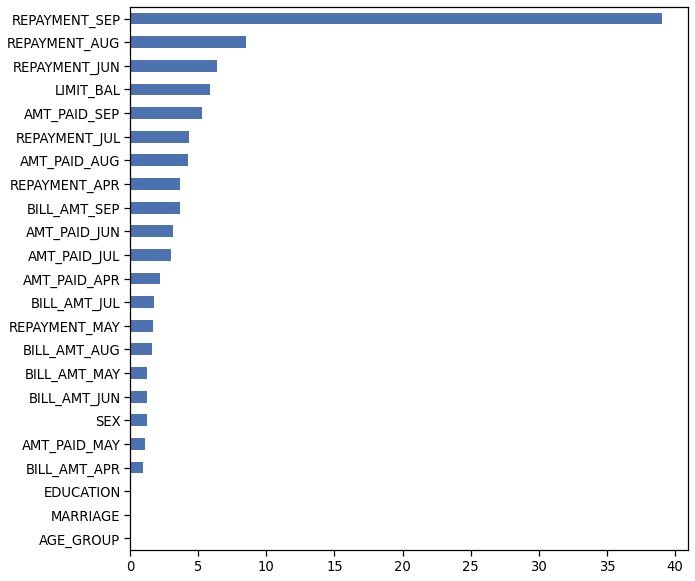

In [72]:
#look at the most important features based on the best rf model
fig, (ax) = plt.subplots(ncols=1, figsize=(10,10))

cb_feat_importances = pd.Series(best_cb.feature_importances_, index=X_cb.columns)

cb_feat_importances.nlargest(30).sort_values(ascending=True).plot(kind='barh')
plt.show()

In [73]:
#use the Catboost model to predict probabilities (of 0 and 1) for each row of the testing data
cbprob = best_cb.predict_proba(X_test_cb)

#put the predicted probabilities into a dataframe
#For probability values, first value is probability of outcome = 0, second value is probability of outcome = 1

cbpredprob = pd.DataFrame({"probabilities":list(cbprob)})

In [74]:
#insert a column to store the rCat Boost classifier probability values
X_testdf['CBPROBABILITIES'] = cbpredprob.values

#create 2 new columns with probability of non-default and default, and drop the cbprobabilities column
X_testdf[['CB_PROB_NONDEFAULT','CB_PROB_DEFAULT']] = pd.DataFrame(X_testdf.CBPROBABILITIES.values.tolist(), index= X_testdf.index)
X_testdf.drop(['CBPROBABILITIES'], axis = 1, inplace=True)

In [75]:
X_testdf.head()

,LIMIT_BAL,REPAYMENT_SEP,REPAYMENT_AUG,REPAYMENT_JUL,REPAYMENT_JUN,REPAYMENT_MAY,REPAYMENT_APR,BILL_AMT_SEP,BILL_AMT_AUG,BILL_AMT_JUL,BILL_AMT_JUN,BILL_AMT_MAY,BILL_AMT_APR,AMT_PAID_SEP,AMT_PAID_AUG,AMT_PAID_JUL,AMT_PAID_JUN,AMT_PAID_MAY,AMT_PAID_APR,AGE_GROUP_20s,AGE_GROUP_30s,AGE_GROUP_40s,AGE_GROUP_50s,AGE_GROUP_60s,AGE_GROUP_70s,SEX_FEMALE,SEX_MALE,EDUCATION_GRADUATE_SCHOOL,EDUCATION_HIGH_SCHOOL,EDUCATION_OTHERS,EDUCATION_UNIVERSITY,EDUCATION_UNKNOWN,MARRIAGE_MARRIED,MARRIAGE_OTHERS,MARRIAGE_SINGLE,MARRIAGE_UNKNOWN,LR_PROB_NONDEFAULT,LR_PROB_DEFAULT,RF_PROB_NONDEFAULT,RF_PROB_DEFAULT,XGB_PROB_NONDEFAULT,XGB_PROB_DEFAULT,LGBM_PROB_NONDEFAULT,LGBM_PROB_DEFAULT,CB_PROB_NONDEFAULT,CB_PROB_DEFAULT
2308,30000,0,0,0,0,0,0,8864,10062,11581,12580,13716,14828,1500,2000,1500,1500,1500,2000,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0.836,0.164,0.840,0.160,0.827,0.173,0.768,0.232,0.832,0.168
22404,150000,0,0,0,0,0,0,136736,125651,116684,101581,77741,77264,4486,4235,3161,2647,2669,2669,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0.871,0.129,0.913,0.087,0.912,0.088,0.894,0.106,0.892,0.108
23397,70000,0,0,0,0,0,0,70122,69080,68530,69753,70111,70212,2431,3112,3000,2438,2500,2554,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0.842,0.158,0.879,0.121,0.859,0.141,0.796,0.204,0.880,0.120
25058,130000,0,0,0,0,0,0,20678,18956,16172,16898,11236,6944,1610,1808,7014,27,7011,4408,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0.852,0.148,0.886,0.114,0.905,0.095,0.910,0.090,0.859,0.141
2664,50000,0,0,0,0,0,2,94228,47635,42361,19574,20295,19439,2000,1500,1000,1800,0,1000,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0.815,0.185,0.810,0.190,0.802,0.198,0.819,0.181,0.806,0.194


# Model Evaluation - Plot AUC curve and predicted probabilities

In [76]:
#get the predic_proba values (i.e., probabilities of classification)

y_pred_proba_LR = best_logreg.predict_proba(X_test_scaled)[::,1]
fpr1, tpr1, _ = metrics.roc_curve(y_test,  y_pred_proba_LR)
auc1 = metrics.roc_auc_score(y_test, y_pred_proba_LR)

y_pred_proba_RF = best_rf.predict_proba(X_test_scaled)[::,1]
fpr2, tpr2, _ = metrics.roc_curve(y_test,  y_pred_proba_RF)
auc2 = metrics.roc_auc_score(y_test, y_pred_proba_RF)

y_pred_proba_XGB = best_xgb.predict_proba(X_test_scaled)[::,1]
fpr3, tpr3, _ = metrics.roc_curve(y_test,  y_pred_proba_XGB)
auc3 = metrics.roc_auc_score(y_test, y_pred_proba_XGB)

y_pred_proba_LGBM = best_lgb.predict_proba(X_test_scaled)[::,1]
fpr4, tpr4, _ = metrics.roc_curve(y_test,  y_pred_proba_LGBM)
auc4 = metrics.roc_auc_score(y_test, y_pred_proba_LGBM)

y_pred_proba_CB = best_cb.predict_proba(X_test_cb)[::,1]
fpr5, tpr5, _ = metrics.roc_curve(y_test_cb,  y_pred_proba_CB)
auc5 = metrics.roc_auc_score(y_test_cb, y_pred_proba_CB)


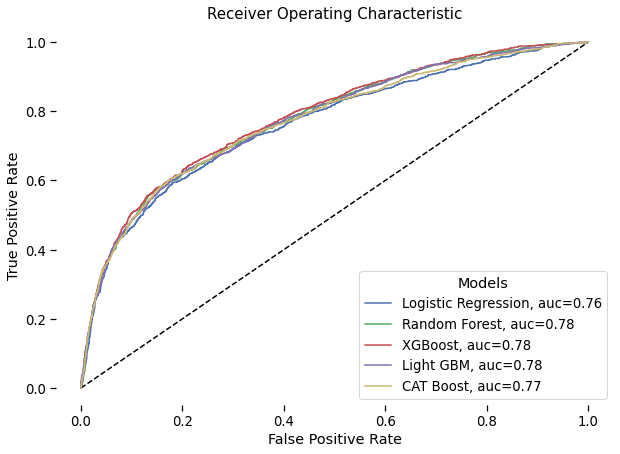

In [77]:
#Plot the ROC

plt.figure(figsize=(10,7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr1,tpr1,label="Logistic Regression, auc="+str(round(auc1,2)))

plt.plot(fpr2,tpr2,label="Random Forest, auc="+str(round(auc2,2)))

plt.plot(fpr3,tpr3,label="XGBoost, auc="+str(round(auc3,2)))

plt.plot(fpr4,tpr4,label="Light GBM, auc="+str(round(auc4,2)))


plt.plot(fpr5,tpr5,label="CAT Boost, auc="+str(round(auc5,2)))

plt.legend(loc=4, title='Models', facecolor='white')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic', size=15)
plt.box(False)
plt.savefig('ImageName', format='png', dpi=200, transparent=True);

In [78]:
#Compare the cross validated models
# Append different best classifier models into a list
models = []

# Logistic Regression
models.append(('logreg',best_logreg))

# Random Forest Classifier
models.append(('randomforest',best_rf))

#XGBoost
models.append(('xgboost',best_xgb))

#LightGBM
models.append(('LightGBM',best_lgb))

# Evaluate each model
results = []
names = []
scoring = 'accuracy'

for name, model in models:
    cv_results = cross_val_score(model, X, y, cv=5, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# evaluate Catboost separately as using different data set
cv_results_cb = cv(Pool(X_cb,y_cb, cat_features=categorical_features_indices),best_cb.get_params(),fold_count=5, verbose_eval= False)
cv_results_cb_append = cv_results_cb["test-Accuracy-mean"].to_numpy()

#append catboost model
results.append(cv_results_cb_append)
names.append('catboost')
msg_cb = "%s: %f (%f)" % ("Catboost", cv_results_cb.mean()[1], cv_results_cb.std()[2])
print("{}. Max accuracy across cv attempts = {}.".format(msg_cb, cv_results_cb['test-Accuracy-mean'].max()))

logreg: 0.817267 (0.008980)
randomforest: 0.820300 (0.009638)
xgboost: 0.820967 (0.009915)
LightGBM: 0.816933 (0.009427)
Catboost: 0.820407 (0.000442). Max accuracy across cv attempts = 0.8210331313277722.


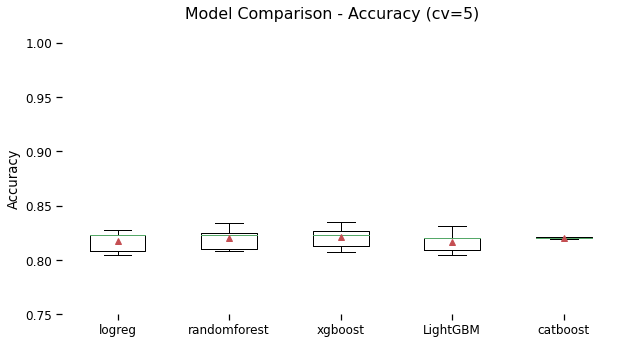

In [79]:
from matplotlib import pyplot
# Plot all the accuracy results vs. each model 
#(model type on the x-axis and accuracy on the y-axis).
fig = pyplot.figure(figsize=(10,5))
sns.set_context('notebook', font_scale=1.1)
fig.suptitle('Model Comparison - Accuracy (cv=5)')
ax = fig.add_subplot(111)
pyplot.boxplot(results, showmeans=True)
ax.set_xticklabels(names)
ax.set_ylabel('Accuracy')
ax.set_ylim([0.75,1])
plt.box(False)
plt.savefig('ImageName', format='png', dpi=200, transparent=True);

In [80]:
#compare the classification report scores
classreport = pd.DataFrame({'model': ['Logistic_Regression','Random_Forest','XGBoost','LightGBM','CATBoost'], 'F1':[0.79, 0.80, 0.80,0.79,0.80], 'Precision':[0.80, 0.80, 0.81,0.80, 0.81], 'Recall':[0.82,0.82,0.82,0.82,0.82]}) 
classreport

,model,F1,Precision,Recall
0,Logistic_Regression,0.790,0.800,0.820
1,Random_Forest,0.800,0.800,0.820
2,XGBoost,0.800,0.810,0.820
3,LightGBM,0.790,0.800,0.820
4,CATBoost,0.800,0.810,0.820


# 4. Further analysis

In [81]:
#check X_testdf

X_testdf.head()

,LIMIT_BAL,REPAYMENT_SEP,REPAYMENT_AUG,REPAYMENT_JUL,REPAYMENT_JUN,REPAYMENT_MAY,REPAYMENT_APR,BILL_AMT_SEP,BILL_AMT_AUG,BILL_AMT_JUL,BILL_AMT_JUN,BILL_AMT_MAY,BILL_AMT_APR,AMT_PAID_SEP,AMT_PAID_AUG,AMT_PAID_JUL,AMT_PAID_JUN,AMT_PAID_MAY,AMT_PAID_APR,AGE_GROUP_20s,AGE_GROUP_30s,AGE_GROUP_40s,AGE_GROUP_50s,AGE_GROUP_60s,AGE_GROUP_70s,SEX_FEMALE,SEX_MALE,EDUCATION_GRADUATE_SCHOOL,EDUCATION_HIGH_SCHOOL,EDUCATION_OTHERS,EDUCATION_UNIVERSITY,EDUCATION_UNKNOWN,MARRIAGE_MARRIED,MARRIAGE_OTHERS,MARRIAGE_SINGLE,MARRIAGE_UNKNOWN,LR_PROB_NONDEFAULT,LR_PROB_DEFAULT,RF_PROB_NONDEFAULT,RF_PROB_DEFAULT,XGB_PROB_NONDEFAULT,XGB_PROB_DEFAULT,LGBM_PROB_NONDEFAULT,LGBM_PROB_DEFAULT,CB_PROB_NONDEFAULT,CB_PROB_DEFAULT
2308,30000,0,0,0,0,0,0,8864,10062,11581,12580,13716,14828,1500,2000,1500,1500,1500,2000,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0.836,0.164,0.840,0.160,0.827,0.173,0.768,0.232,0.832,0.168
22404,150000,0,0,0,0,0,0,136736,125651,116684,101581,77741,77264,4486,4235,3161,2647,2669,2669,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0.871,0.129,0.913,0.087,0.912,0.088,0.894,0.106,0.892,0.108
23397,70000,0,0,0,0,0,0,70122,69080,68530,69753,70111,70212,2431,3112,3000,2438,2500,2554,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0.842,0.158,0.879,0.121,0.859,0.141,0.796,0.204,0.880,0.120
25058,130000,0,0,0,0,0,0,20678,18956,16172,16898,11236,6944,1610,1808,7014,27,7011,4408,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0.852,0.148,0.886,0.114,0.905,0.095,0.910,0.090,0.859,0.141
2664,50000,0,0,0,0,0,2,94228,47635,42361,19574,20295,19439,2000,1500,1000,1800,0,1000,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0.815,0.185,0.810,0.190,0.802,0.198,0.819,0.181,0.806,0.194


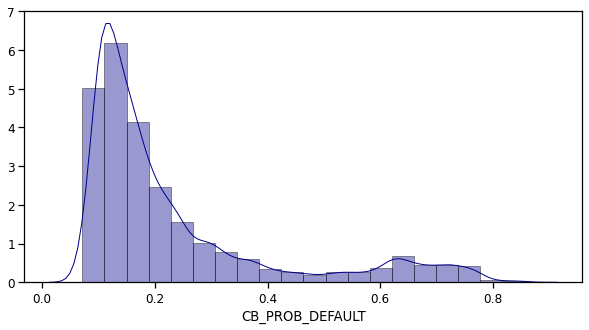

In [82]:
#Selecting CATBoost model as it has the best model accuracy and ROC AUC
#Plot the probability distribution of defaulting from the catboost model


plt.figure(figsize=(10,5))

sns.distplot(X_testdf['CB_PROB_DEFAULT'], hist=True, kde=True, bins=20, color = 'darkblue', hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 1})


In [83]:
#Bin the risk group based on the arbitrary cutoffs

X_testdf['RISK'] = pd.cut(X_testdf['CB_PROB_DEFAULT'], bins=[0.000, 0.200, 0.600,1.000], labels=['LOW_RISK','MEDIUM_RISK','HIGH_RISK'])

X_testdf['RISK'].value_counts()

LOW_RISK       3805
MEDIUM_RISK    1650
HIGH_RISK       545
Name: RISK, dtype: int64

# 4.1 Identify the common characteristics of those labelled High Risk

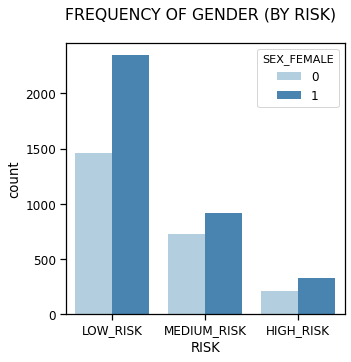

In [84]:
#Get count plots for risk by gender

f, axes = plt.subplots(figsize=(5, 5), facecolor='white')
f.suptitle('FREQUENCY OF GENDER (BY RISK)')
ax1 = sns.countplot(x="RISK", hue="SEX_FEMALE", data=X_testdf, palette="Blues")


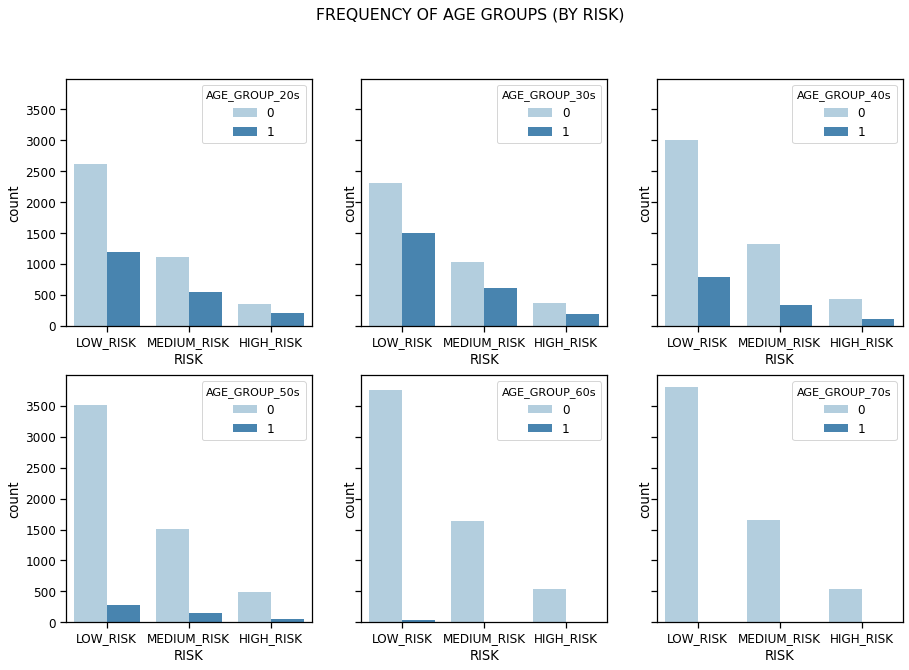

In [85]:
#Get count plots for risk by age groups. 

f, axes = plt.subplots(2, 3, figsize=(15, 10), facecolor='white',sharey=True)
ax.set_ylim([0, 4000])

f.suptitle('FREQUENCY OF AGE GROUPS (BY RISK)')
ax1 = sns.countplot(x="RISK", hue="AGE_GROUP_20s", data=X_testdf, palette="Blues", ax=axes[0,0])
ax2 = sns.countplot(x="RISK", hue="AGE_GROUP_30s", data=X_testdf, palette="Blues", ax=axes[0,1])
ax3 = sns.countplot(x="RISK", hue="AGE_GROUP_40s", data=X_testdf, palette="Blues", ax=axes[0,2])
ax4 = sns.countplot(x="RISK", hue="AGE_GROUP_50s", data=X_testdf, palette="Blues", ax=axes[1,0])
ax5 = sns.countplot(x="RISK", hue="AGE_GROUP_60s", data=X_testdf, palette="Blues", ax=axes[1,1])
ax6 = sns.countplot(x="RISK", hue="AGE_GROUP_70s", data=X_testdf, palette="Blues", ax=axes[1,2])


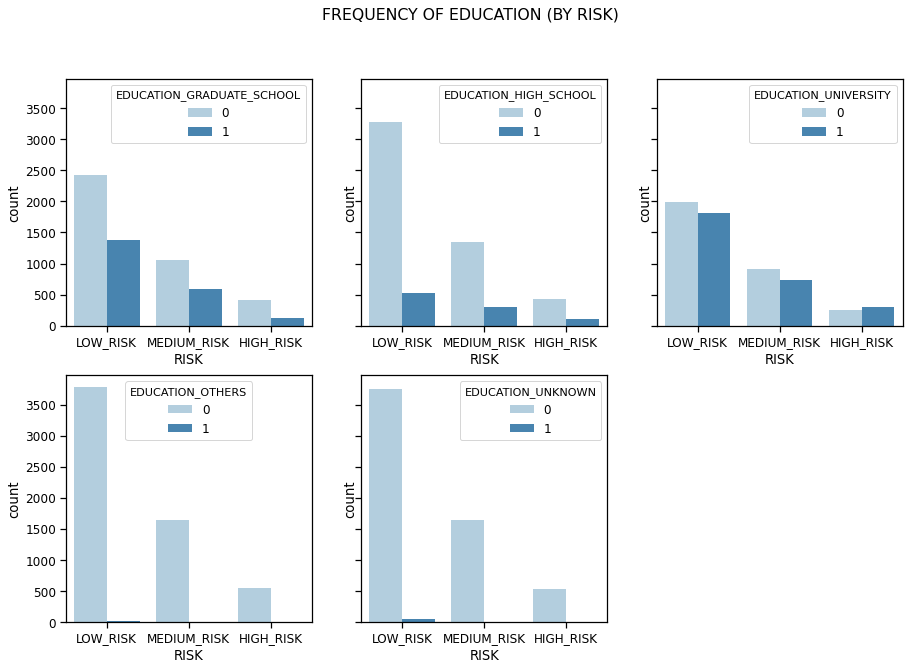

In [86]:
#Get count plots for risk by education. 

f, axes = plt.subplots(2,3,figsize=(15, 10), facecolor='white',sharey=True)
f.suptitle('FREQUENCY OF EDUCATION (BY RISK)')
ax1 = sns.countplot(x="RISK", hue="EDUCATION_GRADUATE_SCHOOL", data=X_testdf, palette="Blues", ax=axes[0,0])
ax2 = sns.countplot(x="RISK", hue="EDUCATION_HIGH_SCHOOL", data=X_testdf, palette="Blues", ax=axes[0,1])
ax3 = sns.countplot(x="RISK", hue="EDUCATION_UNIVERSITY", data=X_testdf, palette="Blues", ax=axes[0,2])
ax4 = sns.countplot(x="RISK", hue="EDUCATION_OTHERS", data=X_testdf, palette="Blues", ax=axes[1,0])
ax5 = sns.countplot(x="RISK", hue="EDUCATION_UNKNOWN", data=X_testdf, palette="Blues", ax=axes[1,1])
f.delaxes(ax=axes[1,2])

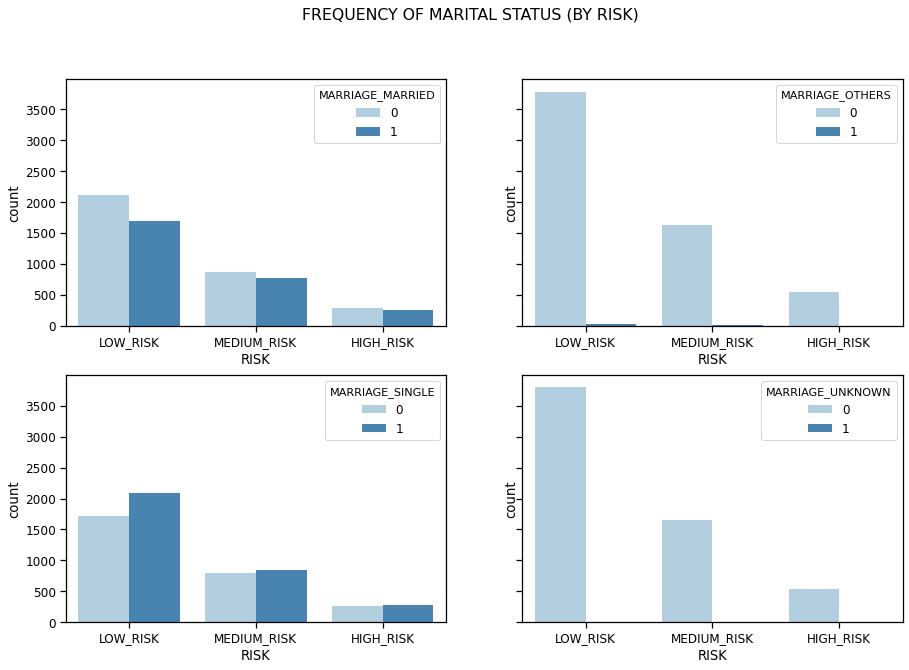

In [87]:
#Get count plots for risk by education. 

f, axes = plt.subplots(2,2,figsize=(15, 10), facecolor='white',sharey=True)
f.suptitle('FREQUENCY OF MARITAL STATUS (BY RISK)')
ax1 = sns.countplot(x="RISK", hue="MARRIAGE_MARRIED", data=X_testdf, palette="Blues", ax=axes[0,0])
ax2 = sns.countplot(x="RISK", hue="MARRIAGE_OTHERS", data=X_testdf, palette="Blues", ax=axes[0,1])
ax3 = sns.countplot(x="RISK", hue="MARRIAGE_SINGLE", data=X_testdf, palette="Blues", ax=axes[1,0])
ax4 = sns.countplot(x="RISK", hue="MARRIAGE_UNKNOWN", data=X_testdf, palette="Blues", ax=axes[1,1])



In [88]:
#find out the common characteristics of high risk group

#Select the high risk group
highrisk = X_testdf.loc[X_testdf['RISK'] == 'HIGH_RISK']

In [89]:
#select the continuous columns
highriskcont = highrisk.iloc[:, 0:19]

highriskcont.head()

,LIMIT_BAL,REPAYMENT_SEP,REPAYMENT_AUG,REPAYMENT_JUL,REPAYMENT_JUN,REPAYMENT_MAY,REPAYMENT_APR,BILL_AMT_SEP,BILL_AMT_AUG,BILL_AMT_JUL,BILL_AMT_JUN,BILL_AMT_MAY,BILL_AMT_APR,AMT_PAID_SEP,AMT_PAID_AUG,AMT_PAID_JUL,AMT_PAID_JUN,AMT_PAID_MAY,AMT_PAID_APR
10784,80000,2,2,2,2,2,2,53843,55933,56575,57303,58593,59738,3500,2100,2200,2300,2200,2100
15947,30000,3,2,2,7,7,7,2400,2400,2400,2400,2400,2400,0,0,0,0,0,0
14980,30000,2,2,2,2,2,2,28224,29276,28635,30127,30525,29793,1800,150,2250,1000,0,700
3673,20000,2,2,2,2,2,0,14328,17196,17418,17608,17187,17528,3114,800,770,0,776,549
8223,30000,4,3,2,2,2,0,30562,29809,28920,29887,29525,25006,0,0,1900,15,1030,30802


In [90]:
#get the summary statistics

highriskcont.describe()

,LIMIT_BAL,REPAYMENT_SEP,REPAYMENT_AUG,REPAYMENT_JUL,REPAYMENT_JUN,REPAYMENT_MAY,REPAYMENT_APR,BILL_AMT_SEP,BILL_AMT_AUG,BILL_AMT_JUL,BILL_AMT_JUN,BILL_AMT_MAY,BILL_AMT_APR,AMT_PAID_SEP,AMT_PAID_AUG,AMT_PAID_JUL,AMT_PAID_JUN,AMT_PAID_MAY,AMT_PAID_APR
count,545.000,545.000,545.000,545.000,545.000,545.000,545.000,545.000,545.000,545.000,545.000,545.000,545.000,545.000,545.000,545.000,545.000,545.000,545.000
mean,96532.110,2.235,1.558,1.417,1.279,1.123,1.061,62543.130,62652.185,60464.593,57577.565,54394.961,53014.982,2875.455,2675.721,2853.703,2315.490,3189.132,3433.708
std,86991.650,0.769,1.207,1.367,1.485,1.465,1.407,72502.723,71622.416,68983.311,67582.181,64721.862,63100.109,4492.372,3937.133,8291.117,3635.457,9730.817,12255.445
min,10000.000,2.000,0.000,0.000,0.000,0.000,0.000,37.000,0.000,-780.000,-350.000,-350.000,-350.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,30000.000,2.000,0.000,0.000,0.000,0.000,0.000,17761.000,18598.000,18398.000,17857.000,16492.000,16182.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,70000.000,2.000,2.000,2.000,2.000,0.000,0.000,41619.000,40931.000,40527.000,35678.000,32185.000,30647.000,2000.000,1744.000,1500.000,1500.000,1300.000,1500.000
75%,130000.000,2.000,2.000,2.000,2.000,2.000,2.000,79026.000,78669.000,77514.000,73690.000,72243.000,71247.000,3500.000,3369.000,3000.000,3000.000,3000.000,3000.000
max,600000.000,8.000,7.000,7.000,7.000,7.000,7.000,564757.000,572834.000,494290.000,470617.000,447203.000,456453.000,59068.000,50189.000,142848.000,51285.000,130000.000,156961.000


# 4.2 Try Synthetic Minority Oversampling Technique (SMOTE) for unbalanced dataset - to increase number of minority cases

In [91]:

print("Before OverSampling, counts of Case label '1': {}".format(sum(y_train == 1))) 
print("Before OverSampling, counts of Control label '0': {} \n".format(sum(y_train == 0))) 
  
# import SMOTE module from imblearn library 
# pip install imblearn (if you don't have imblearn in your system) 
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state = 2) 
X_train_smote, y_train_smote = sm.fit_sample(X_train_scaled, y_train.ravel()) 
  
print('After OverSampling, the shape of X2_train: {}'.format(X_train_smote.shape)) 
print('After OverSampling, the shape of y2_train: {} \n'.format(y_train_smote.shape)) 
  
print("After OverSampling, counts of Case label '1': {}".format(sum(y_train_smote == 1))) 
print("After OverSampling, counts of Control label '0': {}".format(sum(y_train_smote == 0))) 

Before OverSampling, counts of Case label '1': 5323
Before OverSampling, counts of Control label '0': 18677 

After OverSampling, the shape of X2_train: (37354, 36)
After OverSampling, the shape of y2_train: (37354,) 

After OverSampling, counts of Case label '1': 18677
After OverSampling, counts of Control label '0': 18677


# 4.2.1 Using XG Boost for SMOTE as it has the best AUC and best accuracy for 5-fold cross validation

In [92]:
# Create the parameter grid
xgb = XGBClassifier(objective = 'binary:logistic') 

param_grid = [{'max_depth': range(4,10,2), 'n_estimators':[100,500], 'eta':[0.01,0.1], 'colsample_bytree':[0.8,1], 'subsample':[0.8,1] }]

#create svm classifier
xgb_classifier = GridSearchCV(xgb, param_grid, cv = 5, refit = True, verbose = 10, scoring = 'roc_auc', n_jobs=-1) 


# fitting the model for grid search 
xgb_classifier.fit(X_train_smote, y_train_smote.ravel()) 

print("Tuned XGB Parameters: %s" % (xgb_classifier.best_params_))

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 18.5min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 21.2min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 23.2min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 27.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 31

Tuned XGB Parameters: {'colsample_bytree': 1, 'eta': 0.1, 'max_depth': 8, 'n_estimators': 500, 'subsample': 0.8}


Accuracy: 0.7891666666666667

              precision    recall  f1-score   support

           0       0.86      0.87      0.87      4687
           1       0.52      0.52      0.52      1313

    accuracy                           0.79      6000
   macro avg       0.69      0.69      0.69      6000
weighted avg       0.79      0.79      0.79      6000


Average 5-Fold CV Score: 0.821 Standard deviation: 0.0099


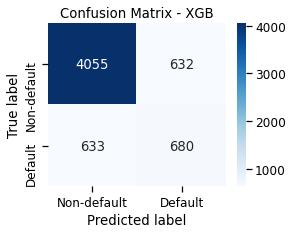

In [93]:
#using the best parameters to train the xgb smote model

best_xgb_smote = XGBClassifier(max_depth=6, n_estimators=500, eta = 0.01, colsample_bytree = 0.8, subsample = 0.8, verbose = True)

best_xgb_smote.fit(X_train_smote, y_train_smote.ravel())

y_pred_smote = best_xgb_smote.predict(X_test_scaled)

print('Accuracy:', metrics.accuracy_score(y_pred_smote,y_test))

## 5-fold cross-validation 
cv_scores =cross_val_score(best_xgb_smote, X, y, cv=5)

# Print the 5-fold cross-validation scores
print()
print(classification_report(y_test, y_pred_smote))
print()
print("Average 5-Fold CV Score: {}".format(round(np.mean(cv_scores),4)),"Standard deviation: {}".format(round(np.std(cv_scores),4)))

#plot the confusion matrix
plt.figure(figsize=(4,3))
ConfMatrix = confusion_matrix(y_test,best_xgb_smote.predict(X_test_scaled))
sns.heatmap(ConfMatrix,annot=True, cmap="Blues", fmt="d", 
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - XGB");


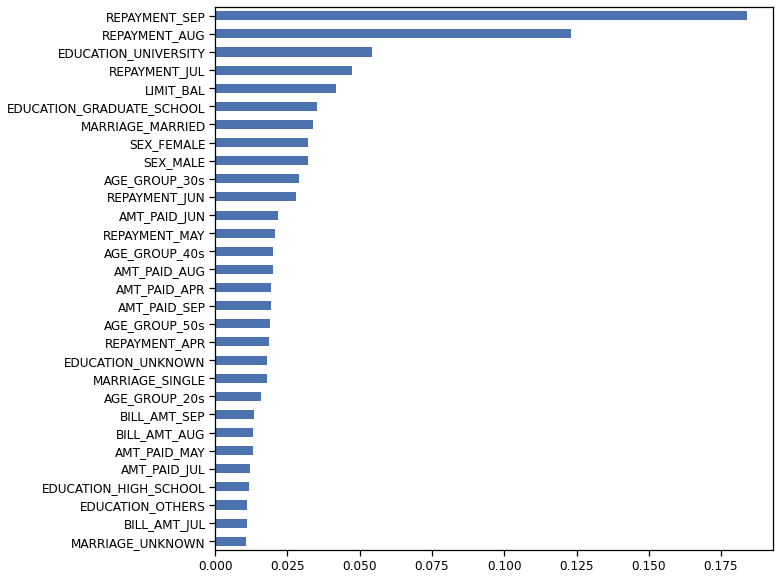

In [95]:
#look at the most important features based on the XGB Smote model
fig, (ax) = plt.subplots(ncols=1, figsize=(10,10))

xgb_smote_feat_importances = pd.Series(best_xgb_smote.feature_importances_, index=X.columns)

xgb_smote_feat_importances.nlargest(30).sort_values(ascending=True).plot(kind='barh')
plt.show()

In [96]:
#use the XGB Smote model to predict probabilities (of 0 and 1) for each row of the testing data
xgbprob_smote = best_xgb_smote.predict_proba(X_test_scaled)

#put the predicted probabilities into a dataframe
#For probability values, first value is probability of outcome = 0, second value is probability of outcome = 1

xgb_smotepredprob = pd.DataFrame({"probabilities":list(xgbprob_smote)})


In [97]:
#insert a column to store the LGBM probability values
X_testdf['XGBSMOTEPROBABILITIES'] = xgb_smotepredprob.values

In [98]:
#create 2 new columns with probability of non-default and default, and drop the xgbprobabilities column
X_testdf[['XGBSMOTE_PROB_NONDEFAULT','XGBSMOTE_PROB_DEFAULT']] = pd.DataFrame(X_testdf.XGBSMOTEPROBABILITIES.values.tolist(), index= X_testdf.index)
X_testdf.drop(['XGBSMOTEPROBABILITIES'], axis = 1, inplace=True)

In [99]:
X_testdf.head()

,LIMIT_BAL,REPAYMENT_SEP,REPAYMENT_AUG,REPAYMENT_JUL,REPAYMENT_JUN,REPAYMENT_MAY,REPAYMENT_APR,BILL_AMT_SEP,BILL_AMT_AUG,BILL_AMT_JUL,BILL_AMT_JUN,BILL_AMT_MAY,BILL_AMT_APR,AMT_PAID_SEP,AMT_PAID_AUG,AMT_PAID_JUL,AMT_PAID_JUN,AMT_PAID_MAY,AMT_PAID_APR,AGE_GROUP_20s,AGE_GROUP_30s,AGE_GROUP_40s,AGE_GROUP_50s,AGE_GROUP_60s,AGE_GROUP_70s,SEX_FEMALE,SEX_MALE,EDUCATION_GRADUATE_SCHOOL,EDUCATION_HIGH_SCHOOL,EDUCATION_OTHERS,EDUCATION_UNIVERSITY,EDUCATION_UNKNOWN,MARRIAGE_MARRIED,MARRIAGE_OTHERS,MARRIAGE_SINGLE,MARRIAGE_UNKNOWN,LR_PROB_NONDEFAULT,LR_PROB_DEFAULT,RF_PROB_NONDEFAULT,RF_PROB_DEFAULT,XGB_PROB_NONDEFAULT,XGB_PROB_DEFAULT,LGBM_PROB_NONDEFAULT,LGBM_PROB_DEFAULT,CB_PROB_NONDEFAULT,CB_PROB_DEFAULT,RISK,XGBSMOTE_PROB_NONDEFAULT,XGBSMOTE_PROB_DEFAULT
2308,30000,0,0,0,0,0,0,8864,10062,11581,12580,13716,14828,1500,2000,1500,1500,1500,2000,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0.836,0.164,0.840,0.160,0.827,0.173,0.768,0.232,0.832,0.168,LOW_RISK,0.643,0.357
22404,150000,0,0,0,0,0,0,136736,125651,116684,101581,77741,77264,4486,4235,3161,2647,2669,2669,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0.871,0.129,0.913,0.087,0.912,0.088,0.894,0.106,0.892,0.108,LOW_RISK,0.761,0.239
23397,70000,0,0,0,0,0,0,70122,69080,68530,69753,70111,70212,2431,3112,3000,2438,2500,2554,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0.842,0.158,0.879,0.121,0.859,0.141,0.796,0.204,0.880,0.120,LOW_RISK,0.731,0.269
25058,130000,0,0,0,0,0,0,20678,18956,16172,16898,11236,6944,1610,1808,7014,27,7011,4408,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0.852,0.148,0.886,0.114,0.905,0.095,0.910,0.090,0.859,0.141,LOW_RISK,0.672,0.328
2664,50000,0,0,0,0,0,2,94228,47635,42361,19574,20295,19439,2000,1500,1000,1800,0,1000,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0.815,0.185,0.810,0.190,0.802,0.198,0.819,0.181,0.806,0.194,LOW_RISK,0.704,0.296


In [100]:
#get the predic_proba values (i.e., probabilities of classification)

y_pred_proba_xgbsmote = best_xgb_smote.predict_proba(X_test_scaled)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_xgbsmote)
auc = metrics.roc_auc_score(y_test, y_pred_proba_xgbsmote)

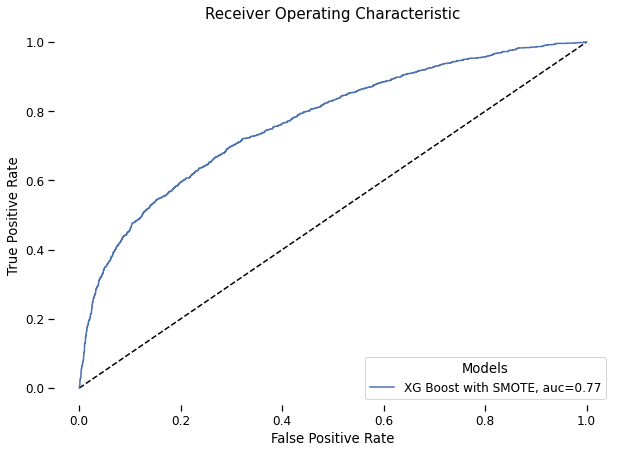

In [101]:
#Plot the ROC

plt.figure(figsize=(10,7))
plt.plot([0, 1], [0, 1], 'k--')

plt.plot(fpr,tpr,label="XG Boost with SMOTE, auc="+str(round(auc,2)))

plt.legend(loc=4, title='Models', facecolor='white')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic', size=15)
plt.box(False)
plt.savefig('ImageName', format='png', dpi=200, transparent=True);

<font color = red> The AUC actually decreased by 0.01 after SMOTE was used